In [9]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
import sys; sys.path.append('/home/pshah/Documents/code/Vape/utils/')
import alloptical_utils_pj as ao
import numpy as np
import utils_funcs as uf
import matplotlib.pyplot as plt
print(sys.path)
import funcs_pj as pjf
import pickle
import pandas

import seaborn as sns
sns.set()

plt.rcParams['figure.figsize'] = [20.0, 3.0]

trial = 't-017'

['/home/pshah', '/Applications/NEURON-7.6/nrn/lib/python', '/home/pshah', '/home/pshah/anaconda3/lib/python37.zip', '/home/pshah/anaconda3/lib/python3.7', '/home/pshah/anaconda3/lib/python3.7/lib-dynload', '', '/home/pshah/anaconda3/lib/python3.7/site-packages', '/home/pshah/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/pshah/.ipython', '/home/pshah/Documents/code/Vape/utils/', '/home/pshah/Documents/code/Vape/', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/home/pshah/Documents/code/Vape/utils/']


In [3]:
###### IMPORT pkl file containing exp_obj
# pkl_path = '/Users/prajayshah/Documents/data-to-process/2020-03-18/2020-03-18_t-019_t-020.pkl'
# pkl_path = "/Volumes/Extreme SSD/oxford-data/2020-03-18/2020-03-18_%s.pkl" % trial
pkl_path = "/home/pshah/mnt/qnap/Data/2020-03-18/J063/2020-03-18_J063_%s/2020-03-18_%s.pkl" % (trial, trial)
with open(pkl_path, 'rb') as f:
    exp_obj = pickle.load(f)


In [5]:
###### suite2p processing  on exp_obj
# s2p_path = '/Volumes/Extreme SSD/oxford-data/2020-03-19/suite2p/find_resp-baseline-t002/plane0'
# s2p_path = '/Volumes/Extreme SSD/oxford-data/2020-03-18/suite2p/find_resp-4ap-t017/plane0'
s2p_path = '/home/pshah/mnt/qnap/Data/2020-03-18/J063/suite2p/find_resp-4ap-t017/plane0'
exp_obj.s2pProcessing(s2p_path=s2p_path)
exp_obj.find_s2p_targets_naparm()

flu, spks, stat = uf.s2p_loader(s2p_path, subtract_neuropil=True)


Loading 439 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7
searching for targeted cells...

SLM Group # 0
Cell # 56 ('y97', 'x218')
Cell # 1187 ('y116', 'x240')
Number of targeted cells: 2

SLM Group # 1
Cell # 46 ('y140', 'x311')
Cell # 268 ('y162', 'x286')
Cell # 293 ('y151', 'x315')
Cell # 346 ('y195', 'x300')
Number of targeted cells: 4

SLM Group # 2
Cell # 5 ('y212', 'x103')
Cell # 163 ('y227', 'x116')
Cell # 187 ('y204', 'x125')
Number of targeted cells: 3

SLM Group # 3
Number of targeted cells: 0

SLM Group # 4
Number of targeted cells: 0

SLM Group # 5
Cell # 85 ('y210', 'x289')
Cell # 102 ('y245', 'x359')
Cell # 165 ('y219', 'x323')
Cell # 628 ('y255', 'x285')
Number of targeted cells: 4

SLM Group # 6
Cell # 154 ('y294', 'x369')
Cell # 209 ('y272', 'x388')
Number of targeted cells: 2

SLM Group # 7
Cell # 125 ('y154', 'x121')
Cell # 321 ('y128', 'x100')
Cell # 404 ('y155', 'x106')
Cell # 404 ('y162', 'x103')
Number of targeted cells: 3

SLM Group # 

In [6]:
# filter cells that are active at least once for >2.5*std across 4 frames (defined as 1 Ca event)
def _good_cells(exp_obj, min_radius_pix, max_radius_pix):
    good_cells = []
    for i in range(len(exp_obj.cell_id)):
        raw = exp_obj.raw[i]
        raw_ = list(np.delete(raw, exp_obj.photostim_frames, None))
        raw_dff = ao.normalize_dff(raw_)
        std = np.std(raw_dff, axis=0)

        x = []
        y = []
        for j in np.arange(len(raw_dff), step=4):
            avg = np.mean(raw_dff[j:j+4])
            if avg > np.mean(raw_dff)+2.5*std: # if the avg of 4 frames is greater than the threshold then save the result
              x.append(j)
              y.append(avg)

        radius = exp_obj.radius[i]

        if len(x) > 0 and radius > min_radius_pix and radius < max_radius_pix:
            good_cells.append(exp_obj.cell_id[i])
    print('# of good cells found: %s (out of %s ROIs)' % (len(good_cells), len(exp_obj.cell_id)))
    return good_cells
exp_obj.good_cells = _good_cells(exp_obj, min_radius_pix=3.5, max_radius_pix=8.5)

# of good cells found: 144 (out of 439 ROIs)


In [7]:
# specify pre-stim and post-stim periods of analysis and plotting
pre_stim = 10
post_stim = 90

# function for gathering all good photostim cells who respond reliably to photostim
def _good_photostim_cells(exp_obj, std_thresh=1, dff_threshold=None, pre_stim=10, post_stim=200):
    '''
    make sure to specify std threshold to use for filtering
    the pre-stim and post-stim args specify which pre-stim and post-stim frames to consider for filtering
    '''
    exp_obj.good_naparm_cells = []
    exp_obj.good_naparm_cells_responses = []
    exp_obj.good_photostim_cells_stim_responses_dF_stdF = []
    exp_obj.good_photostim_cells_stim_responses_dFF = []
    total = 0 # use to tally up how many cells across all groups are filtered in
    total_considered = 0 # use to tally up how many cells were looked at for their photostim response.
    for group in range(len(exp_obj.s2p_targets_naparm)):
        print('\nGroup %s' % group)
        stim_timings = exp_obj.stim_start_frames[0][group::exp_obj.n_groups]
        title = 'SLM naparm Group #%s' % group
        # targeted_cells = exp_obj.s2p_targets_naparm[group]
        targeted_cells = [cell for cell in exp_obj.s2p_targets_naparm[group] if cell in exp_obj.good_cells]

        # collect photostim timed average dff traces of photostim targets
        targets_dff = []
        pre_stim = pre_stim
        post_stim = post_stim
        for cell in targeted_cells:
            # print('considering cell # %s' % cell)
            if cell in exp_obj.cell_id:
                cell_idx = exp_obj.cell_id.index(cell)
                flu = [exp_obj.raw[cell_idx][stim - pre_stim:stim + post_stim] for stim in stim_timings
                       if stim not in exp_obj.seizure_frames]
                # flu = []
                # for stim in stim_timings:
                #     if stim not in exp_obj.seizure_frames:
                #         flu.append(exp_obj.raw[cell_idx][stim - pre_stim:stim + post_stim])

                flu_dff = []
                for trace in flu:
                    mean = np.mean(trace[0:pre_stim])
                    trace_dff = ((trace - mean) / mean) * 100
                    flu_dff.append(trace_dff)

                targets_dff.append(np.mean(flu_dff, axis=0))

        # FILTER CELLS WHERE PHOTOSTIMULATED TARGETS FIRE > 10*std ABOVE PRE-STIM
        good_photostim_responses = {}
        good_photostim_cells = []
        good_targets_dF_stdF = []
        good_targets_dff = []
        std_thresh = std_thresh
        for cell in targeted_cells:
            trace = targets_dff[
                targeted_cells.index(cell)]  # trace = averaged dff trace across all photostims. for this cell
            pre_stim_trace = trace[:pre_stim]
            # post_stim_trace = trace[pre_stim + exp_obj.duration_frames:post_stim]
            mean_pre = np.mean(pre_stim_trace)
            std_pre = np.std(pre_stim_trace)
            # mean_post = np.mean(post_stim_trace[:10])
            dF_stdF = (trace - mean_pre) / std_pre  # make dF divided by std of pre-stim F trace
            # response = np.mean(dF_stdF[pre_stim + exp_obj.duration_frames:pre_stim + 3*exp_obj.duration_frames])
            response = np.mean(trace[pre_stim + exp_obj.duration_frames:pre_stim + 3 * exp_obj.duration_frames]) # calculate the dF over pre-stim mean F response within the response window
            if dff_threshold is None:
                thresh_ = mean_pre + std_thresh * std_pre
            else:
                thresh_ = dff_threshold
            if response > thresh_:  # test if the response passes threshold
                good_photostim_responses[cell] = response
                good_photostim_cells.append(cell)
                good_targets_dF_stdF.append(dF_stdF)
                good_targets_dff.append(trace)
                print('Cell #%s - dFF post-stim: %s (threshold value = %s' % (cell, response, thresh_))

        exp_obj.good_naparm_cells.append(good_photostim_cells)
        exp_obj.good_naparm_cells_responses.append(good_photostim_responses)
        exp_obj.good_photostim_cells_stim_responses_dF_stdF.append(good_targets_dF_stdF)
        exp_obj.good_photostim_cells_stim_responses_dFF.append(good_targets_dff)

        print('%s cells filtered out of %s targeted cells' % (len(good_photostim_cells), len(targeted_cells)))
        total += len(good_photostim_cells)
        total_considered += len(targeted_cells)

    exp_obj.good_naparm_cells_all = [y for x in exp_obj.good_naparm_cells for y in x]
    print('\nTotal number of good photostim responsive cells found: %s (out of %s)' % (total, total_considered))
_good_photostim_cells(exp_obj, pre_stim=pre_stim, post_stim=post_stim, dff_threshold=20)



Group 0
Cell #1187 - dFF post-stim: 46.758053 (threshold value = 20
1 cells filtered out of 1 targeted cells

Group 1
Cell #46 - dFF post-stim: 327.49213 (threshold value = 20
Cell #268 - dFF post-stim: 35.517 (threshold value = 20
Cell #293 - dFF post-stim: 29.705711 (threshold value = 20
3 cells filtered out of 4 targeted cells

Group 2
Cell #187 - dFF post-stim: 219.48615 (threshold value = 20
1 cells filtered out of 1 targeted cells

Group 3
0 cells filtered out of 0 targeted cells

Group 4
0 cells filtered out of 0 targeted cells

Group 5
Cell #102 - dFF post-stim: 480.58368 (threshold value = 20
Cell #628 - dFF post-stim: 30.629173 (threshold value = 20
2 cells filtered out of 2 targeted cells

Group 6
Cell #154 - dFF post-stim: 44.149113 (threshold value = 20
Cell #209 - dFF post-stim: 110.47 (threshold value = 20
2 cells filtered out of 2 targeted cells

Group 7
Cell #321 - dFF post-stim: 127.44131 (threshold value = 20
Cell #404 - dFF post-stim: 150.53943 (threshold value = 2

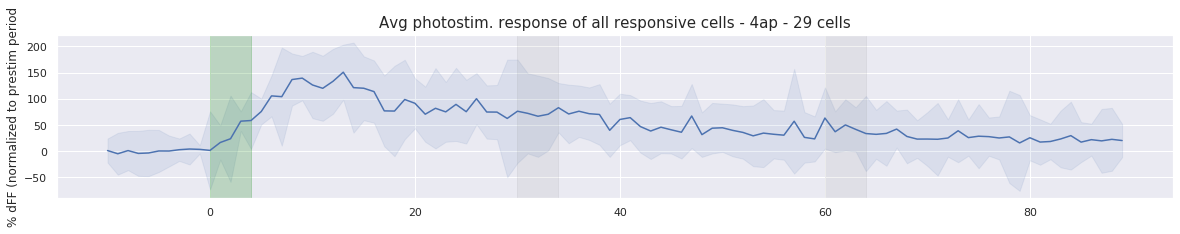

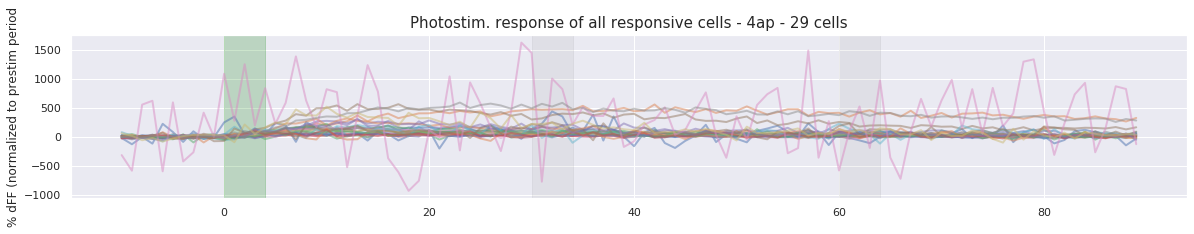

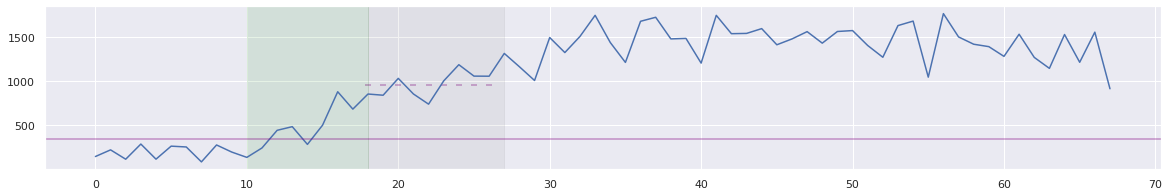

In [10]:
# plot avg photostim response of all responsive cells (i.e. good cells from above filtering steps)
x = [j for i in exp_obj.good_photostim_cells_stim_responses_dFF for j in i]; y_label='% dFF (normalized to prestim period'

# make plots of photostim targeted trials
def plot_photostim_avg(dff_array, stim_duration, pre_stim=10, post_stim=200, title='', y_min=None, y_max=None,
                       x_label=None, y_label=None):
    len_ = len(dff_array)
    flu_avg = np.median(dff_array, axis=0)
    std = np.std(dff_array, axis=0)
    ci = 1.960 * (std / np.sqrt(len_))  # 1.960 is z for 95% confidence interval, standard deviation divided by the sqrt of N samples (# traces in flu_dff)
    x = list(range(-pre_stim, post_stim))
    y = flu_avg

    fig, ax = plt.subplots()
    ax.fill_between(x, (y - ci), (y + ci), color='b', alpha=.1)  # plot confidence interval
    ax.axvspan(0, stim_duration, alpha=0.2, color='green')
    if post_stim > int(exp_obj.fps):
        for i in range(int(exp_obj.fps), post_stim, int(exp_obj.fps)): # make sure to change this based on the fps of the naparm trial imaging
            ax.axvspan(i, i+stim_duration, color='gray', alpha=0.1)
    ax.plot(x, y)
    if y_min != None:
        ax.set_ylim([y_min, y_max])
    ax.set_title((title+' - %s' % len_+' cells'), horizontalalignment='center', verticalalignment='top', pad=20, fontsize=15)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()
def plot_photostim_(dff_array, stim_duration, pre_stim=10, post_stim=200, title='', y_min=None, y_max=None,
                    x_label=None, y_label=None):
    len_ = len(dff_array)
    x = list(range(-pre_stim, post_stim))
    fig, ax = plt.subplots()
    ax.axvspan(0, stim_duration, alpha=0.2, color='green')
    for cell_trace in dff_array:
        ax.plot(x, cell_trace, linewidth=2, alpha=0.5)
    if post_stim > int(exp_obj.fps):
        for i in range(int(exp_obj.fps), post_stim,
                       int(exp_obj.fps)):  # make sure to change this based on the fps of the naparm trial imaging
            ax.axvspan(i, i + stim_duration, color='gray', alpha=0.1)
    if y_min != None:
        ax.set_ylim([y_min, y_max])
    ax.set_title((title + ' - %s' % len_ + ' cells'), horizontalalignment='center', verticalalignment='top', pad=20,
                 fontsize=15)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

plot_photostim_avg(dff_array=x, stim_duration=4, pre_stim=pre_stim, post_stim=post_stim, title='Avg photostim. response of all responsive cells - 4ap', y_label=y_label)
plot_photostim_(dff_array=x, stim_duration=4, pre_stim=pre_stim, post_stim=post_stim, title='Photostim. response of all responsive cells - 4ap', y_label=y_label)

def plot_single_stim_trial(cell, stim_number, stim_frame=None, pre_stim=pre_stim, post_stim=post_stim, x_label=None, y_label=None):
    '''plot a single cell's photostim response on a single stim trial, along with the 1*std pre-stim line'''
    if stim_frame is None:
        group = [exp_obj.good_naparm_cells.index(i) for i in exp_obj.good_naparm_cells if cell in i][0]
        stim_frame = exp_obj.stim_start_frames[0][group::exp_obj.n_groups][stim_number]

    cell_idx = exp_obj.cell_id.index(cell)
    trace = exp_obj.raw[cell_idx][stim_frame-pre_stim:stim_frame+exp_obj.duration_frames+post_stim]
    std_pre = np.std(trace[0:pre_stim])
    pre_stim_mean = np.mean(trace[0:pre_stim])
    response = np.mean(trace[pre_stim+exp_obj.duration_frames: pre_stim + 1 + 2*exp_obj.duration_frames])

    # make plot
    fig, ax = plt.subplots()
    ax.plot(trace)
    x = range(pre_stim+exp_obj.duration_frames, pre_stim + 1 + 2*exp_obj.duration_frames)
    y = [response]*len(x)
    ax.scatter(x=x, y=y, marker='_', alpha=0.4, color='purple')
    ax.axhline(y=pre_stim_mean+2*std_pre, linestyle='-', color = 'purple', alpha=0.4)
    ax.axvspan(pre_stim, pre_stim+exp_obj.duration_frames, color='green', alpha=0.1)
    ax.axvspan(pre_stim+exp_obj.duration_frames, pre_stim + 1 + 2*exp_obj.duration_frames, color='gray', alpha=0.1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()
plot_single_stim_trial(cell=53, stim_number=1, stim_frame=None, pre_stim=pre_stim, post_stim=50)



In [ ]:
# need to define a metric to measure the max. response of the cell in the post-stim period
# create a pandas dataframe to handle collecting this response data from the cells
    # rows: cells
    # columns: group #, all stim_frame_starts (cells not targeted on that stim will have nan as response metric)

# create empty dataframe with the correct rows and columns
d = {}
#d['cells'] = exp_obj.targeted_cells_all
d['groups'] = [int(exp_obj.good_naparm_cells.index(x)) for x in exp_obj.good_naparm_cells for y in x]
for stim in exp_obj.stim_start_frames[0]:
    d['%s' % stim] = [None]*len(exp_obj.good_naparm_cells_all)
df = pd.DataFrame(d, index=exp_obj.good_naparm_cells_all)
# population dataframe
for group in df['groups']:
    stims = exp_obj.stim_start_frames[0][group::exp_obj.n_groups]
    cells = exp_obj.good_naparm_cells[group]
    for stim in stims:
        for cell in cells:
            cell_idx = exp_obj.cell_id.index(cell)
            trace = exp_obj.raw[cell_idx][stim - pre_stim:stim + exp_obj.duration_frames + post_stim]
            mean = np.mean(trace[0:pre_stim])
            trace_dff = ((trace - mean) / abs(mean)) * 100
            std_pre = np.std(trace[0:pre_stim])
            # response = np.mean(trace_dff[pre_stim + exp_obj.duration_frames:pre_stim + 3*exp_obj.duration_frames])
            dF_stdF = (trace - mean) / std_pre  # make dF divided by std of pre-stim F trace
            response = np.mean(dF_stdF[pre_stim + exp_obj.duration_frames:pre_stim + 1 + 2 * exp_obj.duration_frames])
            df.at[cell, '%s' % stim] = response

# average stim response of all cells in that stim group at each stim. timepoint
def plot_stim_responses_stimgroups(title=''):
    '''plot average stim response of each cell at each stim. timepoint, along with the average dFF across all cells at each frame'''
    dff = ao.normalize_dff(exp_obj.raw)
    dff_mean = np.mean(dff, axis=0)

    # use for troubleshooting gathering responses from pandas df
    keys = df.keys()[1:]
    response = [df["%s" % stim].mean() for stim in df.keys()[1:]]
    x = [int(i) for i in keys[pd.notna(response)]]
    y = [a for a in response if str(a) != 'nan']
    #

    fig, ax1 = plt.subplots(figsize=(20,3))
    color = 'gray'
    ax1.plot(dff_mean, color=color, alpha=0.4, linewidth=0.5)
    ax1.tick_params(axis='y', labelcolor=color)
    if type(exp_obj.seizure_frames) == list:
        ax1.axvline(x=exp_obj.seizure_frames[0], color='black')
        ax1.axvline(x=exp_obj.seizure_frames[-1], color='black')

    ax2 = ax1.twinx()

    color = 'black'

    for stim_group in range(exp_obj.n_groups):
        stims = exp_obj.stim_start_frames[0][stim_group::exp_obj.n_groups]
        response = [df["%s" % stim].mean() for stim in stims]
        x = [int(i) for i in stims[pd.notna(response)]]
        y = [a for a in response if str(a) != 'nan']
        ax2.scatter(x, y, s=5)
        ax2.plot(x, y, linewidth=0.5)

    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title((title), horizontalalignment='center', verticalalignment='top', pad=20, fontsize=15)
    fig.show()
plot_stim_responses_stimgroups(title='average stim. response - by stims groups - 4ap')

# individual cell responses at each stim. timepoint
def plot_stim_responses_cells(title=''):
    '''plot average stim response of each cell at each stim. timepoint, along with the average dFF across all cells at each frame'''
    dff = ao.normalize_dff(exp_obj.raw)
    dff_mean = np.mean(dff, axis=0)

    keys = df.keys()[1:]
    response = [df["%s" % stim].mean() for stim in df.keys()[1:]]
    x = [int(i) for i in keys[pd.notna(response)]]
    y = [a for a in response if str(a) != 'nan']


    fig, ax1 = plt.subplots(figsize=(20,3))
    color = 'gray'
    ax1.plot(dff_mean, color=color, alpha=0.4, linewidth=0.5)
    ax1.tick_params(axis='y', labelcolor=color)
    if type(exp_obj.seizure_frames) == list:
        ax1.axvline(x=exp_obj.seizure_frames[0], color='black')
        ax1.axvline(x=exp_obj.seizure_frames[-1], color='black')

    ax2 = ax1.twinx()

    color = 'black'

    for cell in exp_obj.good_naparm_cells_all:
        stim_group = df.loc[cell, 'groups']
        x = exp_obj.stim_start_frames[0][stim_group::exp_obj.n_groups]
        y = [df.loc[cell, '%s' % i] for i in x]
        ax2.scatter(x,y,s=5)
        ax2.plot(x, y, linewidth=0.5)

    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title((title), horizontalalignment='center', verticalalignment='top', pad=20, fontsize=15)
    fig.show()
plot_stim_responses_cells(title='stim. responses - by individual cells - 4ap')

# average stim response of all cells in that stim group at each stim. timepoint - normalized
def plot_stim_responses_norm_cells(title='', norm_start=0, norm_end=exp_obj.n_frames, y_axis_range=[]):
    '''plot average stim response of each cell at each stim. timepoint, along with the average dFF across all cells at each frame'''
    dff = ao.normalize_dff(exp_obj.raw)
    dff_mean = np.mean(dff, axis=0)

    keys = df.keys()[1:]
    response = [df["%s" % stim].mean() for stim in df.keys()[1:]]
    x = [int(i) for i in keys[pd.notna(response)]]
    y = [a for a in response if str(a) != 'nan']


    fig, ax1 = plt.subplots(figsize=(20, 3))
    color = 'gray'
    ax1.plot(dff_mean, color=color, alpha=0.4, linewidth=0.5)
    ax1.tick_params(axis='y', labelcolor=color)
    if type(exp_obj.seizure_frames) == list:
        ax1.axvline(x=exp_obj.seizure_frames[0], color='black')
        ax1.axvline(x=exp_obj.seizure_frames[-1], color='black')

    ax2 = ax1.twinx()
    color = 'black'

    for cell in exp_obj.good_naparm_cells_all:
        stim_group = df.loc[cell, 'groups']
        x = exp_obj.stim_start_frames[0][stim_group::exp_obj.n_groups]
        y = [df.loc[cell, '%s' % i] for i in x]
        mean_ = np.mean([y[i] for i in range(len(x)) if norm_end > x[i] > norm_start])

        y_ = [i/mean_ for i in y] # normalized response of this cell

        ax2.scatter(x, y_, s=5)
        ax2.plot(x, y_, linewidth=0.5)

    ax2.set_ylim(y_axis_range)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title((title), horizontalalignment='center', verticalalignment='top', pad=20, fontsize=15)
    fig.show()
plot_stim_responses_norm_cells(title='stim. responses by individual cells - normalized - 4ap', y_axis_range=[0,3],
                               norm_start=0, norm_end=exp_obj.seizure_frames[0])



In [ ]:
cell = 53
group = [exp_obj.good_naparm_cells.index(i) for i in exp_obj.good_naparm_cells if cell in i][0]  # this will determine which slm group's photostim to plot on the flu trace

# plot flu trace of selected cell with the std threshold
idx = exp_obj.cell_id.index(cell)
def plot_flu_trace(exp_obj=exp_obj, idx=idx, slm_group=group, to_plot_='raw'):
    raw = exp_obj.raw[idx]
    raw_ = list(np.delete(raw, exp_obj.photostim_frames, None))
    raw_dff = ao.normalize_dff(raw_)
    std_dff = np.std(raw_dff, axis=0)
    std = np.std(raw_, axis=0)

    x = []
    #y = []
    for j in np.arange(len(raw_dff), step=4):
        avg = np.mean(raw_dff[j:j + 4])
        if avg > np.mean(raw_dff) + 2.5 * std_dff:
            x.append(j)
            #y.append(0)

    if to_plot_ == 'raw':
        to_plot = raw
        to_thresh = std
    else:
        to_plot = raw_dff
        to_thresh = std_dff

    plt.figure(figsize=(20,3))
    plt.plot(to_plot, linewidth=0.1)
    if to_plot_ == 'raw':
        pass
    else:
        plt.scatter(x, y=[0]*len(x), c='r', linewidth=0.10)
    plt.axhline(y=np.mean(to_plot) + 2.5 * to_thresh, c='green')
    if to_plot_ == 'raw':
        for i in exp_obj.stim_start_frames[0][slm_group::exp_obj.n_groups]:
            plt.axvline(x=i-1, c='gray', alpha=0.1)
    #plt.ylim(0, 300)
    plt.show()
plot_flu_trace(); stat[idx]

In [ ]:
#  plotting the distribution of radius and aspect ratios
radius = []
aspect_ratio = []
for cell in range(len(stat)):
    #if exp_obj.cell_id[cell] in exp_obj.good_cells:
    if exp_obj.cell_id[cell] in exp_obj.cell_id:
        radius.append(stat[cell]['radius'])
        aspect_ratio.append(stat[cell]['aspect_ratio'])

to_plot=radius
n, bins, patches = plt.hist(to_plot, 100)
plt.axvline(3.5)
plt.axvline(8.5)
plt.suptitle('All cells', y=0.95)
plt.show()


In [ ]:
# Pickle the expobject output to save it for analysis
# pkl_path = "/Volumes/Extreme SSD/oxford-data/2020-03-18/2020-03-18_%s.pkl" % trial
pkl_path = "/home/pshah/mnt/qnap/Data/2020-03-18/J063/2020-03-18_J063_%s/2020-03-18_%s.pkl" % (trial, trial)
with open(pkl_path, 'wb') as f:
        pickle.dump(exp_obj, f)
print("pkl saved to %s" % pkl_path)
















In [ ]:
###### photostim analysis - select SLM group to analyse
# select SLM group of cells to analyze
group = 31
stim_timings = exp_obj.stim_start_frames[0][group::exp_obj.duration_frames]
title = 'SLM naparm Group #%s' % group
#targeted_cells = exp_obj.s2p_targets_naparm[group]
targeted_cells = [cell for cell in exp_obj.s2p_targets_naparm[group] if cell in exp_obj.good_cells]
print(targeted_cells)

In [ ]:
###### plot avg traces from PHOTOSTIM TARGETTED cells
# collect photostim timed average dff traces of photostim targets
targets_dff = []
pre_stim = 10
post_stim = 200
for cell in targeted_cells:
    if cell in exp_obj.cell_id:
        cell_idx = exp_obj.cell_id.index(cell)
        flu = []
        for stim in stim_timings:
            #frames_to_plot = list(range(stim-8, stim+35))
            flu.append(exp_obj.raw[cell_idx][stim-pre_stim:stim+post_stim])

        flu_dff = []
        for trace in flu:
            mean = np.mean(trace[0:pre_stim])
            trace_dff = ((trace - mean) / mean) * 100
            flu_dff.append(trace_dff)

        targets_dff.append(np.mean(flu_dff, axis=0))

###### filter cells where photostimulated targets fire >thresh*std above pre-stim
good_photostim_cells = []
good_targets_dF_stdF = []
good_targets_dff = []
std_thresh=2
for cell in targeted_cells:
    trace = targets_dff[targeted_cells.index(cell)] # trace = averaged dff trace across all photostims. for this cell
    pre_stim_trace = trace[:pre_stim]
    post_stim_trace = trace[pre_stim + 4:post_stim] # 4 = stim duration photostim frames
    mean_pre = np.mean(pre_stim_trace)
    std_pre = np.std(pre_stim_trace)
    mean_post = np.mean(post_stim_trace[:10])
    dF_stdF = (trace - mean_pre) / std_pre # make dF divided by std of pre-stim F trace
    response = np.mean(dF_stdF[pre_stim + 4:pre_stim + 10])
    if response > std_thresh:
        good_photostim_cells.append(cell)
        good_targets_dF_stdF.append(dF_stdF)
        good_targets_dff.append(trace)
        print('Cell #%s - dF_stdF post-stim: %s' % (cell, response))
print('%s cells filtered out of %s targeted cells' % (len(good_photostim_cells), len(targeted_cells)))

In [ ]:
# make plots of photostim targeted trials
def plot_photostim_avg(dff_array, stim_duration, pre_stim=10, post_stim=200, title='', y_min=None, y_max=None):
    len_ = len(dff_array)
    flu_avg = np.median(dff_array, axis=0)
    std = np.std(dff_array, axis=0)
    ci = 1.960 * (std / np.sqrt(len_))  # 1.960 is z for 95% confidence interval, standard deviation divided by the sqrt of N samples (# traces in flu_dff)
    x = list(range(-pre_stim, post_stim))
    y = flu_avg

    fig, ax = plt.subplots()
    ax.fill_between(x, (y - ci), (y + ci), color='b', alpha=.1)  # plot confidence interval
    ax.axvspan(0, stim_duration, alpha=0.2, color='green')
    for i in range(15, post_stim, 15): # make sure to change this based on the fps of the naparm trial imaging
        ax.axvspan(i, i+stim_duration, color='gray', alpha=0.1)
    ax.plot(x, y)
    if y_min != None:
        ax.set_ylim([y_min, y_max])
    fig.suptitle((title+' - %s' % len_+' cells'), y=0.95)
    plt.show()
plot_photostim_avg(dff_array=targets_dff, stim_duration=4, pre_stim=pre_stim, post_stim=post_stim, title=title)

def plot_photostim_(dff_array, stim_duration, pre_stim=10, post_stim=200, title='', y_min=None, y_max=None):
    len_ = len(dff_array)
    x = list(range(-pre_stim, post_stim))
    fig, ax = plt.subplots()
    ax.axvspan(0, stim_duration, alpha=0.2, color='green')
    for cell_trace in dff_array:
        ax.plot(x, cell_trace, linewidth='0.5', alpha=0.5)
    for i in range(15, post_stim, 15): # make sure to change this based on the fps of the naparm trial imaging
        ax.axvspan(i, i+stim_duration, color='gray', alpha=0.1)
    if y_min != None:
        ax.set_ylim([y_min, y_max])
    fig.suptitle((title + ' - %s' % len_ + ' cells'), y=0.95)
    plt.show()
# plot_photostim_(dff_array=targets_dff,pre_stim=pre_stim, post_stim=post_stim, title=title)

# check to see what the filtered cells' photostim response look like
plot_photostim_avg(dff_array=good_targets_dff, stim_duration=4, pre_stim=pre_stim, post_stim=post_stim, title=title + ' - filtered - avg of all cells')
plot_photostim_(dff_array=good_targets_dff, stim_duration=4, pre_stim=pre_stim, post_stim=post_stim, title=title + ' - filtered - individual cells')


In [ ]:
# # now plot to see what the dF_stdF trace looks like
# plot_photostim_(dff_array=good_photostimtrials_dFF, pre_stim=pre_stim, post_stim=post_stim, title='good trials dFF')
# plot_photostim_(dff_array=photostimtrials_dFF, pre_stim=pre_stim, post_stim=post_stim, title='dFF')
#
#
# fig, ax = plt.subplots()
# for i in range(len(photostimtrials_dFF)):
#     plt.plot(photostimtrials_dFF[i], linewidth=1.05)
# ax.axvspan(10, 20, alpha=0.2, color='red')
# plt.show()
#
#
# fig, ax = plt.subplots()
# plt.plot(trial_dFF)
# ax.axvspan(10, 20, alpha=0.2, color='red')
# plt.show()

In [ ]:
# # plot raw fluorescence traces
# plt.figure(figsize=(50,3))
# for i in exp_obj.s2p_cell_targets:
#     plt.plot(exp_obj.raw[i], linewidth=0.1)
# plt.xlim(0, len(exp_obj.raw[0]))
# plt.show()

### troubleshoot
import time

def function_x(i, min_radius_pix=3.5, max_radius_pix=8.5):
    raw = exp_obj.raw[i]
    raw_ = list(np.delete(raw, exp_obj.photostim_frames, None))
    raw_dff = ao.normalize_dff(raw_)
    std = np.std(raw_dff, axis=0)

    x = []
    y = []
    for j in np.arange(len(raw_dff), step=4):
        avg = np.mean(raw_dff[j:j+4])
        if avg > np.mean(raw_dff)+2.5*std:
          x.append(j)
          y.append(avg)

    radius = exp_obj.radius[i]

    if len(x) > 0 and radius > min_radius_pix and radius < max_radius_pix:
        return exp_obj.cell_id[i]

start = time.time()
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(10)
good_cells = pool.map(function_x, range(len(exp_obj.cell_id)))
print('# of good cells found: %s (out of %s ROIs)' % (len(good_cells), len(exp_obj.cell_id)))
exp_obj.good_cells = good_cells
# close the pool and wait for the work to finish
pool.close()
pool.join()

end = time.time()

print("total time for multi-thread: ", end-start)

In [ ]:
######
# TODO plot flu avg of ALL cells in FOV after photostim pre and post-4ap - figure out why some DFF values are so large
# collect photostim timed average dff traces
# stim_timings = exp_obj.stim_start_frames[0][0::2] # change x in [x::2] to 0 for SLM group #1 and to 1 for SLM group #2
stim_timings = stim_timings
title = 'All cells DFF - SLM Group #2'
all_cells_dff = []
pre_stim = 10
post_stim = 250
good_std_cells = []
# TODO separate out excitation of cells, inhibition of cells, and no-response of cells (non-targeted cells)
good_std_cells_dff_exc = []
good_std_cells_dff_inh = []
for cell in exp_obj.good_cells:
    if cell in exp_obj.cell_id:
        cell_idx = exp_obj.cell_id.index(cell)
        flu = []
        for stim in stim_timings:
            #frames_to_plot = list(range(stim-8, stim+35))
            flu.append(exp_obj.raw[cell_idx][stim-pre_stim:stim+post_stim])

        flu_dff = []
        for trace in flu:
            mean = np.mean(trace[0:pre_stim])
            trace_dff = ((trace - mean) / mean) * 100
            flu_dff.append(trace_dff)

        all_cells_dff.append(np.mean(flu_dff, axis=0))

        thresh = np.mean(np.mean(flu_dff, axis=0)[pre_stim+10:pre_stim+100])
        if thresh > 30:
            good_std_cells.append(cell)
            good_std_cells_dff_exc.append(np.mean(flu_dff, axis=0))
        elif thresh < -30:
            good_std_cells.append(cell)
            good_std_cells_dff_inh.append(np.mean(flu_dff, axis=0))

        flu_std = []
        std = np.std(flu)
        mean = np.mean(flu[0:pre_stim])
        for trace in flu:
            df_stdf = (trace - mean)/std
            flu_std.append(df_stdf)

        # thresh = np.mean(np.mean(flu_std, axis=0)[pre_stim+10:pre_stim+30])
        #
        # if thresh > 1*std:
        #     good_std_cells.append(cell)
        #     good_std_cells_dff_exc.append(np.mean(flu_dff, axis=0))
        # elif thresh < -1*std:
        #     good_std_cells.append(cell)
        #     good_std_cells_dff_inh.append(np.mean(flu_dff, axis=0))

        print('Pre-stim mean:', mean)
        print('Pre-stim std:', std)
        print('Post-stim dff:', thresh)
        print('                            ')

        # flu_avg = np.mean(flu_dff, axis=0)
        # std = np.std(flu_dff, axis=0)
        # ci = 1.960 * (std/np.sqrt(len(flu_dff))) # 1.960 is z for 95% confidence interval, standard deviation divided by the sqrt of N samples (# traces in flu_dff)
        # x = list(range(-pre_stim, post_stim))
        # y = flu_avg
        #
        # fig, ax = plt.subplots()
        # ax.fill_between(x, (y - ci), (y + ci), color='b', alpha=.1) # plot confidence interval
        # ax.axvspan(0, 10, alpha=0.2, color='red')
        # ax.plot(x, y)
        # fig.suptitle('Cell %s' % cell)
        # plt.show()



ao.plot_photostim_avg(dff_array=all_cells_dff, pre_stim=pre_stim, post_stim=post_stim, title=title)


################
cell_idx = exp_obj.cell_id.index(3863)
std = np.std(exp_obj.raw[cell_idx])
mean = np.mean(exp_obj.raw[cell_idx])

plt.figure(figsize=(50,3))
fig, ax = plt.subplots()
ax.axhline(mean+2.5*std)
plt.plot(exp_obj.raw[cell_idx])
fig.show()


# TODO define cells in proximity of the targeted cell and plot the flu of those pre and post-4ap
# - maybe make like a heatmap around the cell that is being photostimed
# Action plan:
# - make a dictionary for every cell that was targeted (and found in suite2p) that contains:
#   - coordinates of the cell
#   - trials that were successful in raising the fluorescence at least 30% over pre-stim period
#   - other cells that are in 300um proximity of the targeted cell

# TODO photostimulation of targeted cells before CSD, just after CSD, and a while after CSD

# TODO photostimulation of targeted cells before seizure, just after seizure, and a while after seizure





################
# TODO perform analysis for Naparm trials

